<a href="https://colab.research.google.com/github/ReyhanFar16/analysis-mindset-student/blob/main/analisis_pola_pikir_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Analisis Pola Pikir Siswa SD Menggunakan NLP dan ML (Versi Final)**

**1. Instalasi Library**

In [ ]:
# Install library yang diperlukan
%pip install --quiet gspread gspread-dataframe oauth2client sastrawi nltk scikit-learn imbalanced-learn wordcloud matplotlib seaborn pandas openpyxl

**2. Import Library Utama**

In [ ]:
import pandas as pd
import numpy as np
import string
import re
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_dataframe import set_with_dataframe

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 150)


try:
    stopwords.words('indonesian')
except LookupError:
    nltk.download('stopwords')
try:
    word_tokenize('test')
except LookupError:
    nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**3. Upload File JSON Kredensial Google Cloud**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving analisis-sentimen-459700-e123914e2f3e.json to analisis-sentimen-459700-e123914e2f3e (1).json


**4. Koneksi ke Google Sheets dan Pengambilan Data**

In [ ]:
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
keyfile_name = list(uploaded.keys())[0]
credentials = ServiceAccountCredentials.from_json_keyfile_name(keyfile_name, scope)
client = gspread.authorize(credentials)

spreadsheet_name = "Analisis Sentimen Sekolah Madrasah Kelas 5 (Responses)"
try:
    spreadsheet = client.open(spreadsheet_name)
    print(f"Berhasil membuka spreadsheet: {spreadsheet_name}")
except Exception as e:
    print(f"Gagal membuka spreadsheet. Error: {e}")
    print("Pastikan nama spreadsheet benar, file kredensial valid, dan API Google Sheets & Drive diaktifkan.")

kelas_list = ['Kelas 5A', 'Kelas 5B', 'Kelas 5C', 'Kelas 5D']
all_data = []

if 'spreadsheet' in locals():
    for kelas in kelas_list:
        try:
            sheet = spreadsheet.worksheet(kelas)
            records = sheet.get_all_records()
            for row in records:
                row['Kelas_Asal'] = kelas
            all_data.extend(records)
            print(f"Data dari {kelas} berhasil diambil ({len(records)} baris).")
        except gspread.exceptions.WorksheetNotFound:
            print(f"Worksheet {kelas} tidak ditemukan.")
        except Exception as e:
            print(f"Error saat mengambil data dari {kelas}: {e}")

if not all_data:
    print("Tidak ada data yang berhasil diambil. Proses dihentikan.")
else:
    df_initial = pd.DataFrame(all_data)
    print(f"\nTotal {len(df_initial)} baris data berhasil digabungkan.")


    relevant_columns = [
        'Timestamp', 'Nama', 'Kelas_Asal', 'Jenis Kelamin', 'Umur',
        'Diantar Pakai Apa ke Sekolah ?',
        '1. Kamu suka mata pelajaran apa ? alasannya apa?',
        '2. Kalian suka metode pembelajaran seperti apa? alasannya apa?',
        '3. Hambatan belajar di kelas itu apa aja?',
        '4. Kegiatan kesukaan kalian di sekolah apa?',
        '5. Makanan kesukaan kamu itu apa?',
        '6. Uang jajan kamu di sekolah berapa? dan untuk apa?',
        '7. Kalau ada pelajaran atau tugas yang menurutmu susah banget, apa yang biasanya kamu lakukan atau pikirkan?',
        '8. Pernahkah kamu merasa gagal atau membuat kesalahan besar saat belajar atau mengerjakan tugas di sekolah?',
        '9. Menurutmu, apa sih yang membuat seseorang bisa jadi pintar atau jago dalam suatu pelajaran?',
        '10. Kalau gurumu memberikan masukan atau kritik tentang pr atau tugasmu, misalnya ada yang perlu diperbaiki, bagaimana biasanya reaksimu?'
    ]
    existing_columns = [col for col in relevant_columns if col in df_initial.columns]
    df = df_initial[existing_columns].copy()

    column_mapping = {
        '1. Kamu suka mata pelajaran apa ? alasannya apa?': 'Q1_Pelajaran_Suka',
        '2. Kalian suka metode pembelajaran seperti apa? alasannya apa?': 'Q2_Metode_Belajar',
        '3. Hambatan belajar di kelas itu apa aja?': 'Q3_Hambatan_Belajar',
        '4. Kegiatan kesukaan kalian di sekolah apa?': 'Q4_Kegiatan_Suka',
        '5. Makanan kesukaan kamu itu apa?': 'Q5_Makanan_Suka',
        '6. Uang jajan kamu di sekolah berapa? dan untuk apa?': 'Q6_Uang_Jajan',
        '7. Kalau ada pelajaran atau tugas yang menurutmu susah banget, apa yang biasanya kamu lakukan atau pikirkan?': 'Q7_Hadapi_Kesulitan',
        '8. Pernahkah kamu merasa gagal atau membuat kesalahan besar saat belajar atau mengerjakan tugas di sekolah?': 'Q8_Pengalaman_Gagal',
        '9. Menurutmu, apa sih yang membuat seseorang bisa jadi pintar atau jago dalam suatu pelajaran?': 'Q9_Definisi_Pintar',
        '10. Kalau gurumu memberikan masukan atau kritik tentang pr atau tugasmu, misalnya ada yang perlu diperbaiki, bagaimana biasanya reaksimu?': 'Q10_Respon_Kritik'
    }
    df.rename(columns=column_mapping, inplace=True)
    print("\nContoh data setelah seleksi dan penggantian nama kolom (5 baris pertama):")
    display(df.head())

Berhasil membuka spreadsheet: Analisis Sentimen Sekolah Madrasah Kelas 5 (Responses)
Data dari Kelas 5A berhasil diambil (23 baris).
Data dari Kelas 5B berhasil diambil (21 baris).
Data dari Kelas 5C berhasil diambil (25 baris).
Data dari Kelas 5D berhasil diambil (23 baris).

Total 92 baris data berhasil digabungkan.

Contoh data setelah seleksi dan penggantian nama kolom (5 baris pertama):


,Timestamp,Nama,Kelas_Asal,Jenis Kelamin,Umur,Diantar Pakai Apa ke Sekolah ?,Q1_Pelajaran_Suka,Q2_Metode_Belajar,Q3_Hambatan_Belajar,Q4_Kegiatan_Suka,Q5_Makanan_Suka,Q6_Uang_Jajan,Q7_Hadapi_Kesulitan,Q8_Pengalaman_Gagal,Q9_Definisi_Pintar,Q10_Respon_Kritik
0,4/11/2025 8:02:59,Bayazid maxelmina kunthara,Kelas 5A,Laki laki,11 tahun,motor,B.indonesia Karena Suka membaca,Menonton Mudah di pahami,Diajak ngobrol teman,Classmetting,Mie Ayam,10,"Aku coba terus sampai bisa. Kadang aku istirahat dulu sebentar, minum, baru coba lagi","Pernah, waktu itu pas ulangan matematika dapet nilai jelek banget",NaN,"Aku nanya dulu, mana yang salah dan mana yang harus dibenerin"
1,4/11/2025 8:05:45,fathih rava assyaukani,Kelas 5A,Laki laki,11 tahun,Motor,Olahraga Karena bisa maen bola,Kerja kelompok karena ngerjainya bareng bareng,Di ganggu teman,Classmetting,Rendang,10,"Aku tanya Mama atau Papa di rumah. Kalau di sekolah, aku beraniin tanya Bu Guru.","Sering sih, kalau pas tanya jawab terus salah mulu",NaN,Aku diem dan dengerin baik baik
2,4/11/2025 8:50:20,Ahmad Syahid Roisulirfan,Kelas 5A,Laki laki,11 tahun,Motor,Komputer karena Bisa Sambil bermain,Percobaan,Gak bisa fokus,Classmetting,Sate padang,2,Aku mikir sendiri dan kasih semangat untuk diri aku sendiri,"Kadang kadang, karena aku salah kasih jawaban pas kerja kelompok, terus akhirnya nilainya jelek",NaN,Aku terima dan aku benerin yang salahnya
3,4/11/2025 8:54:30,Faeyza abqari ismail,Kelas 5A,Laki laki,11 tahun,Motor,Komputer dan olahraga Karena komputer bisa ke google kalau olahraga bisa maen bola,Menonton karena seru,Tidak suka menulis dan menulis terus,EFT,Indomie,5,Aku minta ajarin teman sebangku yang sudah ngerti. Biasanya dia mau bantu,"Pernah, pas hafalan agama. Disitu aku merasa gagal",NaN,"Kadang aku iyain aja, soalnya kadang masih bingungin"
4,4/11/2025 8:57:55,Noah Aska Kian Mahendra,Kelas 5A,Laki laki,11 tahun,Motor,Olahraga Karena Bisa bermain dan tidak belajar materi,Belajar sambil bermain,Diganggu teman,Supercamp,Sate padang,10.000 buat jajan atau ga beli mainan,Aku baca lagi bukunya pelan-pelan. Kadang aku lihat contoh soal yang mirip,"gk pernah, karena aku belajar pelan pelan dan udah terbiasa deh",NaN,Aku dengerin baik baik dan aku perbaiki yang salahnya


**5. Pra-pemrosesan Teks Lanjutan**

In [ ]:
slang_dict = {
    "bingrish": "bahasa inggris", "bindonesia": "bahasa indonesia", "barab": "bahasa arab",
    "berdiskusi": "diskusi", "pai": "pendidikan agama islam", "pelajaran": "pelajaran",
    "belajar": "belajar", "pjok" : "olahraga", "p5" : "pancasila", "ipa": "ilmu pengetahuan alam", "ips": "ilmu pengetahuan sosial",
    "quranummi" : "quran ummi", "bakalan" : "akan", "gak": "tidak", "ga": "tidak", "gk": "tidak",
    "nggak": "tidak", "tdk": "tidak", "utk": "untuk", "dg": "dengan", "dgn": "dengan",
    "yg": "yang", "dlm": "dalam", "krn": "karena", "bgmn": "bagaimana", "dr": "dari",
    "bgt": "banget", "gini": "begini", "gitu": "begitu", "skrg": "sekarang", "kyk": "kayak",
    "org": "orang", "trs": "terus", "sdh": "sudah", "blm": "belum", "br": "baru", "lg": "lagi",
    "bnyk": "banyak", "dpt": "dapat", "sy": "saya", "kl": "kalau", "sm": "sama", "ttp": "tetap",
    "emg": "memang", "bkn": "bukan", "kpd": "kepada", "pdhl": "padahal", "bbrp": "beberapa"
}

factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words_indonesian = list(stopwords.words('indonesian'))
additional_stopwords = [
    'sih', 'dong', 'deh', 'kok', 'nya', 'ya', 'aja', 'kan', 'tuh', 'pas', 'kalo', 'klo', 'gini', 'gitu',
    'kayak', 'kayaknya', 'biar', 'ayo', 'yuk', 'nah', 'lho', 'sbb', 'dll', 'dst', 'dsb', 'dkk', 'spt',
    'loh', 'banget', 'sangat', 'sekali', 'amat', 'benar', 'iya', 'oke', 'ok', 'sip', 'hehe', 'wkwk', 'ha'
]
stop_words_indonesian.extend(additional_stopwords)
stop_words_indonesian = set(stop_words_indonesian)

def normalize_slang(text):
    text = str(text).lower()
    words = text.split()
    normalized_words = [slang_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

def clean_text(text):
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def stem_text(text):
    return stemmer.stem(str(text))

def remove_stopwords_from_text(text):
    words = str(text).split()
    filtered_words = [word for word in words if word not in stop_words_indonesian and len(word)>1]
    return ' '.join(filtered_words)

def preprocess_full_text(text):
    if pd.isna(text) or text == '':
        return ""
    text = normalize_slang(text)
    text = clean_text(text)
    text = stem_text(text)
    text = remove_stopwords_from_text(text)
    return text

mindset_response_cols = [
    'Q1_Pelajaran_Suka', 'Q2_Metode_Belajar', 'Q3_Hambatan_Belajar',
    'Q7_Hadapi_Kesulitan', 'Q8_Pengalaman_Gagal', 'Q9_Definisi_Pintar', 'Q10_Respon_Kritik'
]

if 'df' in locals():
    for col in mindset_response_cols:
        if col in df.columns:
            df[f'{col}_processed'] = df[col].apply(preprocess_full_text)
        else:
            print(f"Peringatan: Kolom '{col}' tidak ditemukan di DataFrame.")

    processed_cols_to_join_ml = [f'{col}_processed' for col in mindset_response_cols if f'{col}_processed' in df.columns]
    if processed_cols_to_join_ml:
        df['all_processed_text_ml'] = df[processed_cols_to_join_ml].apply(lambda x: ' '.join(x.astype(str)), axis=1)
        print("\nContoh hasil pra-pemrosesan gabungan untuk ML (5 baris pertama):")
        display(df[['Nama', 'all_processed_text_ml']].head())
    else:
        print("Tidak ada kolom hasil proses yang bisa digabungkan untuk ML.")
else:
    print("DataFrame 'df' belum terdefinisi.")


Contoh hasil pra-pemrosesan gabungan untuk ML (5 baris pertama):


,Nama,all_processed_text_ml
0,Bayazid maxelmina kunthara,bindonesia suka baca tonton mudah paham ajak ngobrol teman coba kadang istirahat sebentar minum coba ulang matematika dapet nilai jelek nanya sal...
1,fathih rava assyaukani,olahraga maen bola kerja kelompok ngerjainya bareng bareng ganggu teman mama papa rumah sekolah beraniin bu guru salah mulu diem dengerin
2,Ahmad Syahid Roisulirfan,komputer main coba fokus mikir kasih semangat kadang kadang salah kasih kerja kelompok nilai jelek terima benerin salah
3,Faeyza abqari ismail,komputer olahraga komputer google olahraga maen bola tonton seru suka tulis tulis ajarin teman bang ngerti bantu hafal agama situ gagal kadang iy...
4,Noah Aska Kian Mahendra,olahraga main ajar materi ajar main ganggu teman baca buku pelanpelan kadang lihat contoh ajar pelan pelan udah dengerin salah


**6. Analisis Mindset Awal Berbasis Aturan (Rule-Based)**

Menggunakan teks yang sudah diproses (`all_processed_text_ml`) untuk konsistensi.

Contoh Hasil Analisis Berbasis Aturan (5 baris pertama):


,Nama,Kelas_Asal,Rule_Kategori,Rule_Analisis,Pos_Keywords,Neg_Keywords
0,Bayazid maxelmina kunthara,Kelas 5A,growth mindset,"Indikasi kuat growth mindset. (Pos: 5, Neg: 1)",5,1
1,fathih rava assyaukani,Kelas 5A,fixed mindset,"Cenderung fixed mindset. (Pos: 0, Neg: 1)",0,1
2,Ahmad Syahid Roisulirfan,Kelas 5A,cukup seimbang/perlu observasi,"Indikasi mindset positif dan negatif seimbang. (Pos: 2, Neg: 2)",2,2
3,Faeyza abqari ismail,Kelas 5A,growth mindset,"Cenderung growth mindset. (Pos: 3, Neg: 1)",3,1
4,Noah Aska Kian Mahendra,Kelas 5A,growth mindset,"Cenderung growth mindset. (Pos: 3, Neg: 1)",3,1


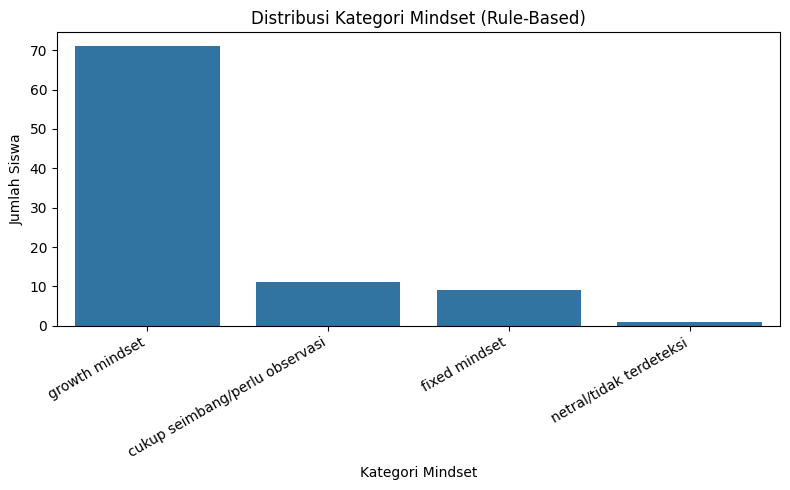

In [ ]:
def analyze_responses_rule_based(response_text):
    positive_keywords = set([
        'suka', 'senang', 'mudah', 'menyenang', 'baik', 'seru', 'semangat',
        'usaha', 'coba', 'ajar', 'pasti', 'bisa',
        'menyerah', 'pantang', 'tantang', 'ingin', 'tahu', 'penasaran',
        'rajin', 'tekun', 'latih', 'paham', 'erti', 'jadi', 'lebih',
        'kembang', 'tingkat', 'solusi', 'pecah', 'asik', 'optimis',
        'yakin', 'bangga', 'manfaat', 'bantu', 'tarik', 'tanya', 'masuk', 'perbaik'
    ])
    negative_keywords = set([
        'hambat', 'sulit', 'malas', 'susah', 'bingung', 'pusing',
        'tidak', 'mustahil', 'percuma', 'gagal', 'bosan',
        'mau', 'capai',
        'nanti', 'tunda', 'penting', 'takut', 'khawatir', 'cemas',
        'sedih', 'marah', 'kesal', 'hindar', 'salah', 'sulitnya'
    ])

    words_in_response = str(response_text).lower().split()
    positive_count = sum(1 for word in words_in_response if word in positive_keywords)
    negative_count = sum(1 for word in words_in_response if word in negative_keywords)

    # Checking
    if "tidak menyerah" in response_text or "pantang menyerah" in response_text:
        positive_count += 2
        if "menyerah" in negative_keywords: negative_count = max(0, negative_count -1)
    if "tidak bisa" in response_text or "tidak dapat" in response_text:
        negative_count += 1
        if "bisa" in positive_keywords: positive_count = max(0, positive_count -1)
    if "tidak mau" in response_text:
        negative_count += 1
        if "mau" in negative_keywords: negative_count = max(0, negative_count -1)
    if "tidak suka" in response_text:
        negative_count +=1
        if "suka" in positive_keywords: positive_count = max(0, positive_count -1)

    category = "netral/tidak terdeteksi"
    description = "Tidak terdeteksi kata kunci pola pikir yang dominan."
    threshold_diff = 2
    min_keywords_strong = 3

    if positive_count > negative_count:
        category = "growth mindset"
        description = "Cenderung growth mindset."
        if positive_count > negative_count + threshold_diff and positive_count >= min_keywords_strong:
             description = "Indikasi kuat growth mindset."
    elif negative_count > positive_count:
        category = "fixed mindset"
        description = "Cenderung fixed mindset."
        if negative_count > positive_count + threshold_diff and negative_count >= min_keywords_strong:
            description = "Indikasi kuat fixed mindset, perlu perhatian."
    else:
        if positive_count == 0 and negative_count == 0:
            category = "netral/tidak terdeteksi"
            description = "Tidak ada kata kunci mindset yang terdeteksi."
        elif positive_count > 0 :
            category = "cukup seimbang/perlu observasi"
            description = "Indikasi mindset positif dan negatif seimbang."

    return category, description, positive_count, negative_count

if 'df' in locals() and 'all_processed_text_ml' in df.columns:
    rule_based_results_list = []
    for index, row in df.iterrows():
        category, description, pos_count, neg_count = analyze_responses_rule_based(row['all_processed_text_ml'])
        rule_based_results_list.append({
            'Nama': row['Nama'],
            'Kelas_Asal': row.get('Kelas_Asal', 'N/A'),
            'Rule_Kategori': category,
            'Rule_Analisis': f"{description} (Pos: {pos_count}, Neg: {neg_count})",
            'Pos_Keywords': pos_count,
            'Neg_Keywords': neg_count
        })

    result_df_rules = pd.DataFrame(rule_based_results_list)
    print("Contoh Hasil Analisis Berbasis Aturan (5 baris pertama):")
    display(result_df_rules.head())

    plt.figure(figsize=(8, 5))
    sns.countplot(data=result_df_rules, x='Rule_Kategori', order=result_df_rules['Rule_Kategori'].value_counts().index)
    plt.title('Distribusi Kategori Mindset (Rule-Based)')
    plt.xlabel('Kategori Mindset')
    plt.ylabel('Jumlah Siswa')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("DataFrame 'df' atau kolom 'all_processed_text_ml' belum ada.")

**7. Persiapan Data untuk Machine Learning**

In [ ]:
if 'df' in locals() and 'result_df_rules' in locals() and 'all_processed_text_ml' in df.columns:
    df_for_ml = df.copy()
    df_for_ml['Target_Kategori'] = result_df_rules['Rule_Kategori']

    X = df_for_ml['all_processed_text_ml']
    y = df_for_ml['Target_Kategori']

    # remove empty text
    empty_text_indices = X[X.str.strip() == ''].index
    if not empty_text_indices.empty:
        print(f"Menemukan {len(empty_text_indices)} baris dengan teks kosong. Menghapusnya...")
        X = X.drop(empty_text_indices)
        y = y.drop(empty_text_indices)
        df_for_ml = df_for_ml.drop(empty_text_indices)
        print(f"Ukuran data setelah penghapusan: {len(X)} baris.")

    if len(X) == 0:
        print("Tidak ada data tersisa setelah menghapus baris kosong. Proses ML tidak dapat dilanjutkan.")
    else:
        vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.9)
        X_tfidf = vectorizer.fit_transform(X)
        print(f"Shape matriks TF-IDF: {X_tfidf.shape}")

        # Checking
        class_counts = y.value_counts()
        if (class_counts < 2).any() and len(y.unique()) > 1:
            print("Peringatan: Ada kelas dengan kurang dari 2 sampel. Stratify mungkin error.")
            print("Menggunakan train_test_split tanpa stratify jika jumlah kelas unik > 1.")
            stratify_option = None
        elif len(y.unique()) == 1:
            print("Peringatan: Hanya ada satu kelas dalam data target. Stratify tidak dapat digunakan.")
            stratify_option = None
        else:
            stratify_option = y

        X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=42, stratify=stratify_option)

        print("\nDistribusi kelas pada y_train:")
        print(y_train.value_counts(normalize=True).sort_index())
        print("\nDistribusi kelas pada y_test:")
        print(y_test.value_counts(normalize=True).sort_index())

        # Save df_for_ml and y_test to analyst the mistakes
        df_test_for_error_analysis = df_for_ml.loc[y_test.index]
else:
    print("Data X dan y untuk ML belum siap.")

Shape matriks TF-IDF: (92, 227)
Peringatan: Ada kelas dengan kurang dari 2 sampel. Stratify mungkin error.
Menggunakan train_test_split tanpa stratify jika jumlah kelas unik > 1.

Distribusi kelas pada y_train:
Target_Kategori
cukup seimbang/perlu observasi    0.130435
fixed mindset                     0.057971
growth mindset                    0.797101
netral/tidak terdeteksi           0.014493
Name: proportion, dtype: float64

Distribusi kelas pada y_test:
Target_Kategori
cukup seimbang/perlu observasi    0.086957
fixed mindset                     0.217391
growth mindset                    0.695652
Name: proportion, dtype: float64


**8. Pelatihan Model Awal (Baseline - Multinomial Naive Bayes)**

Laporan Klasifikasi Model Naive Bayes Baseline:
                                precision    recall  f1-score   support

cukup seimbang/perlu observasi       0.00      0.00      0.00         2
                 fixed mindset       0.00      0.00      0.00         5
                growth mindset       0.70      1.00      0.82        16
       netral/tidak terdeteksi       0.00      0.00      0.00         0

                      accuracy                           0.70        23
                     macro avg       0.17      0.25      0.21        23
                  weighted avg       0.48      0.70      0.57        23



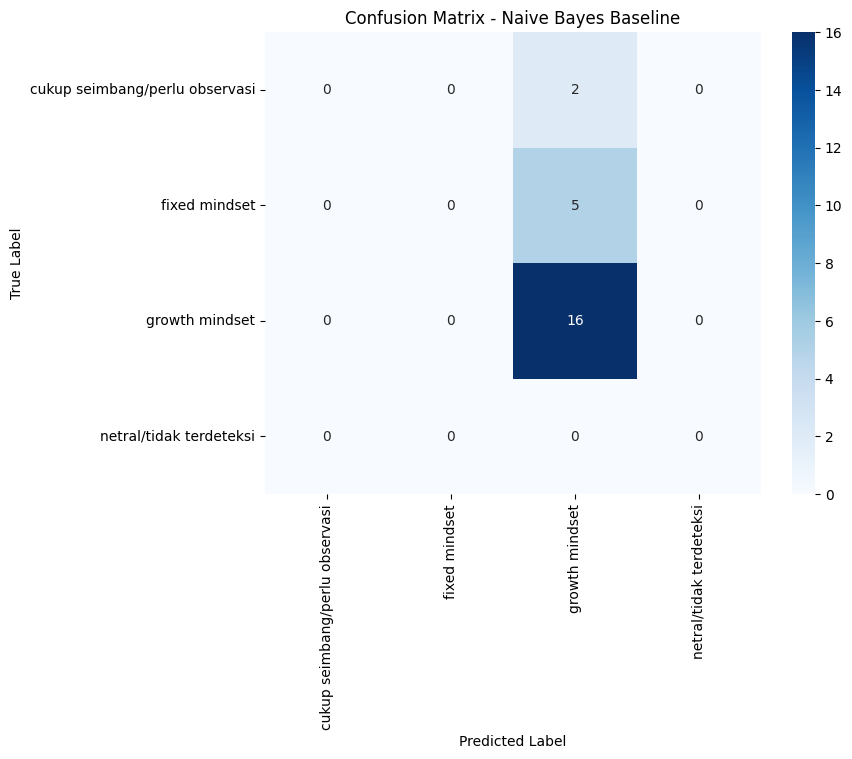

In [ ]:
if 'X_train' in locals() and X_train.shape[0] > 0:
    model_nb_baseline = MultinomialNB(alpha=1.0)
    model_nb_baseline.fit(X_train, y_train)
    y_pred_baseline = model_nb_baseline.predict(X_test)

    unique_labels_report = sorted(y.unique())
    print("Laporan Klasifikasi Model Naive Bayes Baseline:")
    print(classification_report(y_test, y_pred_baseline, labels=unique_labels_report, zero_division=0))

    cm_baseline = confusion_matrix(y_test, y_pred_baseline, labels=unique_labels_report)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels_report, yticklabels=unique_labels_report)
    plt.title('Confusion Matrix - Naive Bayes Baseline')
    plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.show()
else:
    print("Data training (X_train) kosong atau belum ada.")

**9. Mengatasi Ketidakseimbangan Kelas**

**a. SMOTE (Synthetic Minority Over-sampling Technique)**

Distribusi y_train SEBELUM SMOTE: Counter({'growth mindset': 55, 'cukup seimbang/perlu observasi': 9, 'fixed mindset': 4, 'netral/tidak terdeteksi': 1})
Kelas minoritas hanya memiliki 1 sampel. SMOTE tidak dapat diterapkan. Menggunakan data training asli.

Laporan Klasifikasi Naive Bayes dengan SMOTE:
                                precision    recall  f1-score   support

cukup seimbang/perlu observasi       0.00      0.00      0.00         2
                 fixed mindset       0.00      0.00      0.00         5
                growth mindset       0.70      1.00      0.82        16
       netral/tidak terdeteksi       0.00      0.00      0.00         0

                      accuracy                           0.70        23
                     macro avg       0.17      0.25      0.21        23
                  weighted avg       0.48      0.70      0.57        23



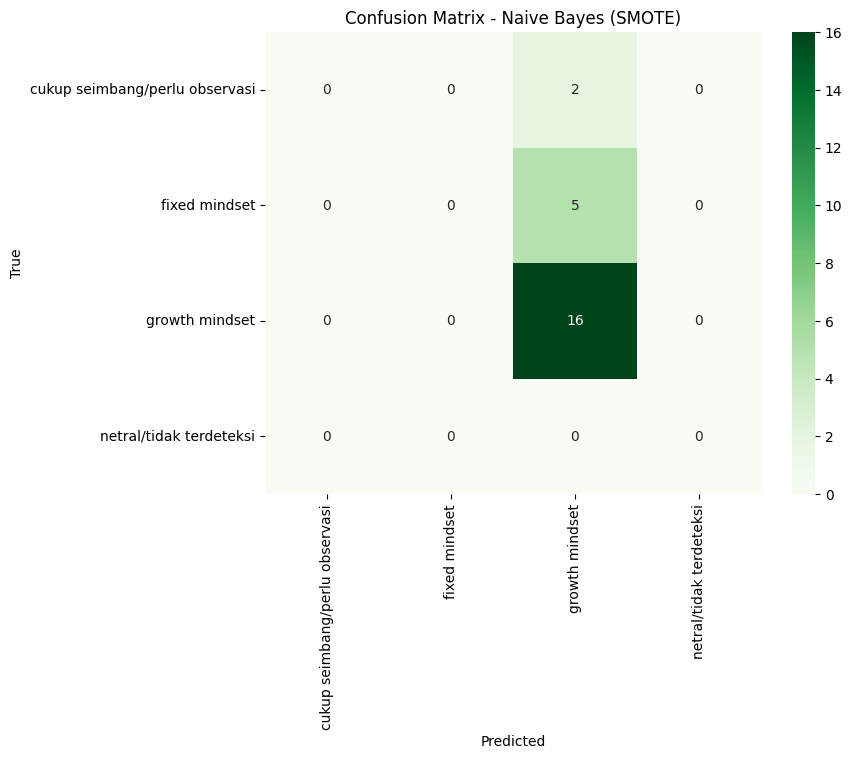

In [ ]:
if 'X_train' in locals() and X_train.shape[0] > 0:
    print("Distribusi y_train SEBELUM SMOTE:", Counter(y_train))

    min_samples_for_smote = y_train.value_counts().min()
    k_neighbors_smote = max(1, min_samples_for_smote - 1) if min_samples_for_smote > 1 else 1

    X_train_resampled, y_train_resampled = X_train, y_train
    model_nb_smote = None

    if min_samples_for_smote > k_neighbors_smote or (min_samples_for_smote == 1 and k_neighbors_smote ==1 and len(y_train.unique()) > 1) :
        if min_samples_for_smote > 1:
            smote = SMOTE(random_state=42, k_neighbors=k_neighbors_smote)
            try:
                X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
                print("Distribusi y_train SETELAH SMOTE:", Counter(y_train_resampled))
            except ValueError as e:
                print(f"Error SMOTE: {e}. Menggunakan data training asli.")
        else:
            print("Kelas minoritas hanya memiliki 1 sampel. SMOTE tidak dapat diterapkan. Menggunakan data training asli.")
    else:
        print(f"Tidak dapat menerapkan SMOTE karena k_neighbors ({k_neighbors_smote}) tidak valid untuk jumlah sampel kelas minoritas ({min_samples_for_smote}). Menggunakan data training asli.")

    if X_train_resampled.shape[0] > 0:
        model_nb_smote = MultinomialNB(alpha=1.0)
        model_nb_smote.fit(X_train_resampled, y_train_resampled)
        y_pred_smote = model_nb_smote.predict(X_test)
        print("\nLaporan Klasifikasi Naive Bayes dengan SMOTE:")
        print(classification_report(y_test, y_pred_smote, labels=unique_labels_report, zero_division=0))

        cm_smote = confusion_matrix(y_test, y_pred_smote, labels=unique_labels_report)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Greens', xticklabels=unique_labels_report, yticklabels=unique_labels_report)
        plt.title('Confusion Matrix - Naive Bayes (SMOTE)'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()
    else:
        print("Data training resampled kosong, tidak bisa melatih model dengan SMOTE.")
else:
    print("Data training (X_train) kosong atau belum ada.")

**b. Pembobotan Kelas (Class Weights) - Logistic Regression & SVM**

Laporan Klasifikasi Logistic Regression (class_weight='balanced'):
                                precision    recall  f1-score   support

cukup seimbang/perlu observasi       0.00      0.00      0.00         2
                 fixed mindset       0.00      0.00      0.00         5
                growth mindset       0.70      1.00      0.82        16
       netral/tidak terdeteksi       0.00      0.00      0.00         0

                      accuracy                           0.70        23
                     macro avg       0.17      0.25      0.21        23
                  weighted avg       0.48      0.70      0.57        23



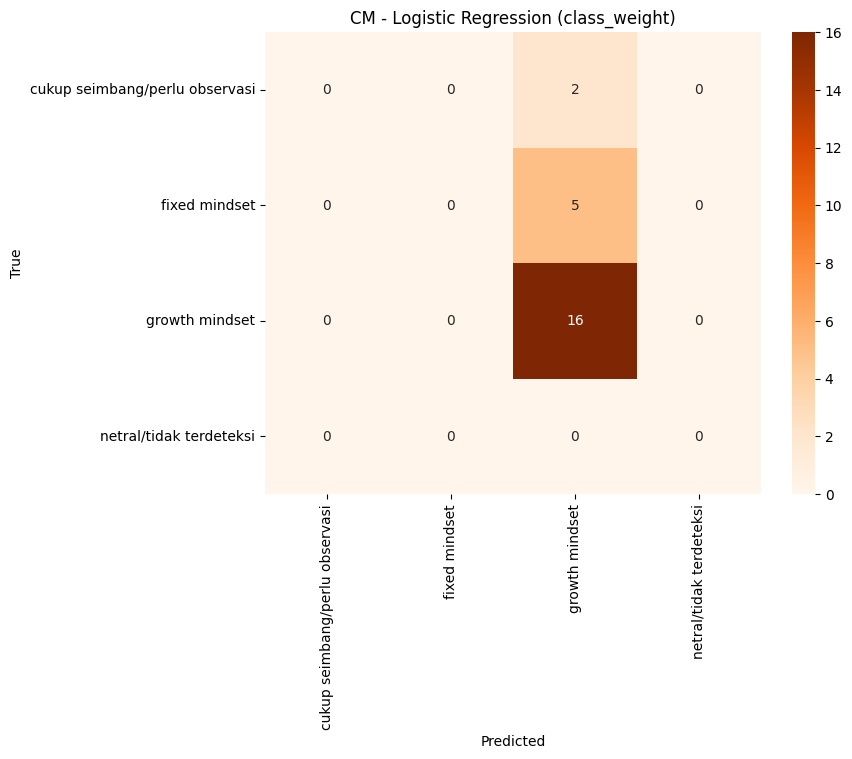


Laporan Klasifikasi SVM (class_weight='balanced'):
                                precision    recall  f1-score   support

cukup seimbang/perlu observasi       0.00      0.00      0.00         2
                 fixed mindset       0.00      0.00      0.00         5
                growth mindset       0.70      1.00      0.82        16
       netral/tidak terdeteksi       0.00      0.00      0.00         0

                      accuracy                           0.70        23
                     macro avg       0.17      0.25      0.21        23
                  weighted avg       0.48      0.70      0.57        23



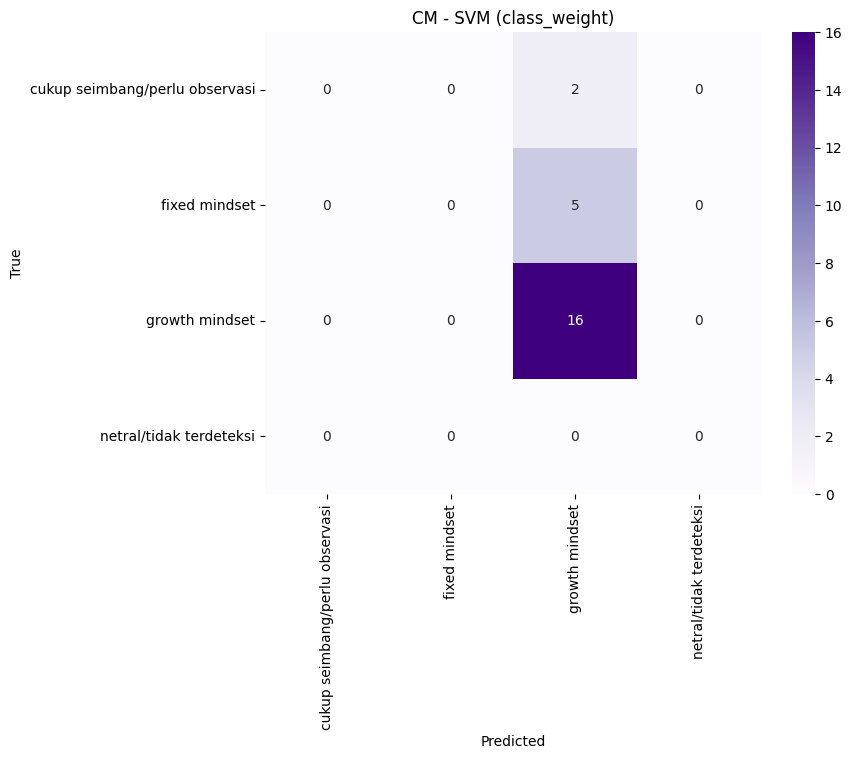

In [ ]:
if 'X_train' in locals() and X_train.shape[0] > 0:
    model_lr_balanced = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42, max_iter=1000)
    model_lr_balanced.fit(X_train, y_train)
    y_pred_lr_balanced = model_lr_balanced.predict(X_test)
    print("Laporan Klasifikasi Logistic Regression (class_weight='balanced'):")
    print(classification_report(y_test, y_pred_lr_balanced, labels=unique_labels_report, zero_division=0))
    cm_lr = confusion_matrix(y_test, y_pred_lr_balanced, labels=unique_labels_report)
    plt.figure(figsize=(8,6)); sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Oranges', xticklabels=unique_labels_report, yticklabels=unique_labels_report)
    plt.title('CM - Logistic Regression (class_weight)'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

    # SVM dengan Class Weight
    model_svm_balanced = SVC(class_weight='balanced', random_state=42, probability=True)
    model_svm_balanced.fit(X_train, y_train)
    y_pred_svm_balanced = model_svm_balanced.predict(X_test)
    print("\nLaporan Klasifikasi SVM (class_weight='balanced'):")
    print(classification_report(y_test, y_pred_svm_balanced, labels=unique_labels_report, zero_division=0))
    cm_svm = confusion_matrix(y_test, y_pred_svm_balanced, labels=unique_labels_report)
    plt.figure(figsize=(8,6)); sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples', xticklabels=unique_labels_report, yticklabels=unique_labels_report)
    plt.title('CM - SVM (class_weight)'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()
else:
    print("Data training (X_train) kosong atau belum ada.")

**10. Optimasi Hyperparameter (GridSearchCV untuk Logistic Regression)**

In [ ]:
if 'X_train_resampled' in locals() and X_train_resampled.shape[0] > 0:
    current_X_train_gs = X_train_resampled
    current_y_train_gs = y_train_resampled

    param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2']
}

    # Filter kombinasi solver & penalty yang valid
    valid_param_grid = []
    for C_val in param_grid_lr['C']:
      for solver_val in param_grid_lr['solver']:
        for penalty_val in param_grid_lr['penalty']:
          if solver_val == 'liblinear' and penalty_val in ['l1', 'l2']:
            valid_param_grid.append({'C': C_val, 'solver': [solver_val], 'penalty': [penalty_val]})
          elif solver_val == 'saga' and penalty_val in ['l1', 'l2', 'elasticnet']:
            if penalty_val in ['l1', 'l2']:
                 valid_param_grid.append({'C': C_val, 'solver': [solver_val], 'penalty': [penalty_val]})

    if not valid_param_grid:
        print("Grid parameter tidak valid. Cek konfigurasi.")
    else:
        grid_search_lr = GridSearchCV(LogisticRegression(random_state=42, max_iter=3000),
                                      valid_param_grid,
                                      cv=2,
                                      scoring='f1_weighted',
                                      verbose=1, n_jobs=-1)
        print("Memulai GridSearchCV untuk Logistic Regression...")
        try:
            grid_search_lr.fit(current_X_train_gs, current_y_train_gs)
            print("\nParameter terbaik:", grid_search_lr.best_params_)
            print("Skor F1 weighted CV terbaik:", grid_search_lr.best_score_)

            best_lr_model_gs = grid_search_lr.best_estimator_
            y_pred_best_lr_gs = best_lr_model_gs.predict(X_test)
            print("\nLaporan Klasifikasi Logistic Regression Terbaik (GridSearchCV):")
            print(classification_report(y_test, y_pred_best_lr_gs, labels=unique_labels_report, zero_division=0))
            cm_gs = confusion_matrix(y_test, y_pred_best_lr_gs, labels=unique_labels_report)
            plt.figure(figsize=(8,6)); sns.heatmap(cm_gs, annot=True, fmt='d', cmap='viridis', xticklabels=unique_labels_report, yticklabels=unique_labels_report)
            plt.title('CM - Logistic Regression Terbaik (GridSearchCV)'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()
        except Exception as e:
            print(f"Error GridSearchCV: {e}")
else:
    print("Data training resampled (X_train_resampled) kosong atau belum ada.")

Memulai GridSearchCV untuk Logistic Regression...
Error GridSearchCV: Parameter grid for parameter 'C' needs to be a list or a numpy array, but got 0.01 (of type float) instead. Single values need to be wrapped in a list with one element.


**11. Analisis Kesalahan & Skor Kepercayaan**

In [ ]:
chosen_model_final = None
model_name_final = "Belum Dipilih"

if 'best_lr_model_gs' in locals() and best_lr_model_gs is not None:
    chosen_model_final = best_lr_model_gs
    model_name_final = "Logistic Regression (GridSearchCV)"
elif 'model_svm_balanced' in locals() and model_svm_balanced is not None:
    chosen_model_final = model_svm_balanced
    model_name_final = "SVM (class_weight='balanced')"
elif 'model_lr_balanced' in locals() and model_lr_balanced is not None:
    chosen_model_final = model_lr_balanced
    model_name_final = "Logistic Regression (class_weight='balanced')"
elif 'model_nb_smote' in locals() and model_nb_smote is not None:
    chosen_model_final = model_nb_smote
    model_name_final = "Naive Bayes (SMOTE)"
elif 'model_nb_baseline' in locals() and model_nb_baseline is not None:
    chosen_model_final = model_nb_baseline
    model_name_final = "Naive Bayes Baseline"

if chosen_model_final and 'X_test' in locals() and 'y_test' in locals() and 'df_test_for_error_analysis' in locals():
    print(f"Analisis kesalahan untuk model: {model_name_final}")
    y_pred_final_analysis = chosen_model_final.predict(X_test)

    misclassified_list = []
    for i, true_label in enumerate(y_test):
        predicted_label = y_pred_final_analysis[i]
        if true_label != predicted_label:
            original_row = df_test_for_error_analysis.iloc[i]
            misclassified_list.append({
                'Nama': original_row['Nama'],
                'Kelas_Asal': original_row['Kelas_Asal'],
                'Teks_Input_ML': original_row['all_processed_text_ml'][:250],
                'Label_Rule_Based_Asli': true_label,
                'Label_Prediksi_ML': predicted_label
            })
    df_misclassified_final = pd.DataFrame(misclassified_list)
    print(f"\nJumlah kesalahan: {len(df_misclassified_final)} dari {len(y_test)} sampel uji.")
    if not df_misclassified_final.empty:
        print("Contoh Kesalahan Klasifikasi:")
        display(df_misclassified_final.head())

    if hasattr(chosen_model_final, 'predict_proba'):
        probabilities_final = chosen_model_final.predict_proba(X_test)
        df_probas = pd.DataFrame(probabilities_final, columns=chosen_model_final.classes_, index=y_test.index)
        df_probas = df_probas.merge(df_test_for_error_analysis[['Nama', 'Target_Kategori']], left_index=True, right_index=True)
        df_probas['Predicted_by_ML'] = y_pred_final_analysis


        cols_order = ['Nama', 'Target_Kategori', 'Predicted_by_ML'] + list(chosen_model_final.classes_)
        df_probas = df_probas[cols_order]
        print("\nContoh Skor Kepercayaan (Probabilitas) Model Terbaik:")
        display(df_probas.head())
else:
    print("Model/data untuk analisis kesalahan belum siap.")

Analisis kesalahan untuk model: SVM (class_weight='balanced')

Jumlah kesalahan: 7 dari 23 sampel uji.
Contoh Kesalahan Klasifikasi:


,Nama,Kelas_Asal,Teks_Input_ML,Label_Rule_Based_Asli,Label_Prediksi_ML
0,Kenzie Faeyza Edwar,Kelas 5B,bindonesia ajar games fokus ganggu teman nanya abang jago matematika gagal kasar ajar sekolah rumah langsung tugas salah,cukup seimbang/perlu observasi,growth mindset
1,Maryam Izzata Khairunnisa,Kelas 5C,indonesia baca buku ceramah dengar ganggu teman kelas berisik susah diem meja lupa bawa buku lks latih rumah diem takut salah,fixed mindset,growth mindset
2,Muhammad Alviansyah,Kelas 5B,komputer ajar kelas fokus susah susah salah quiz malu niat ajar rajin kerjainnya,cukup seimbang/perlu observasi,growth mindset
3,Aisyah Rahma Karenina,Kelas 5A,pjok sehat tubuh main ajar matematika sulit temu terkadang diem kesal susah study tour kesasar ken nang capek kerjainnya,fixed mindset,growth mindset
4,Kaffie Al ghifari,Kelas 5B,bingrish games ganggu teman main game kerjain rajin takut gagal nanya guru nilai bagus langsung meja guru,fixed mindset,growth mindset



Contoh Skor Kepercayaan (Probabilitas) Model Terbaik:


,Nama,Target_Kategori,Predicted_by_ML,cukup seimbang/perlu observasi,fixed mindset,growth mindset,netral/tidak terdeteksi
40,Kenzie Faeyza Edwar,cukup seimbang/perlu observasi,growth mindset,0.136559,0.069825,0.778239,0.015377
22,Achmad Ghani Athallah Ardiansya,growth mindset,growth mindset,0.117444,0.033768,0.825176,0.023612
55,Maryam Izzata Khairunnisa,fixed mindset,growth mindset,0.143601,0.079788,0.751289,0.025323
72,Keisha Tri Ramadhani,growth mindset,growth mindset,0.127804,0.041792,0.826500,0.003903
0,Bayazid maxelmina kunthara,growth mindset,growth mindset,0.132591,0.042602,0.804245,0.020562


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**12. Visualisasi Word Clouds (berdasarkan kategori dari Rule-Based)**

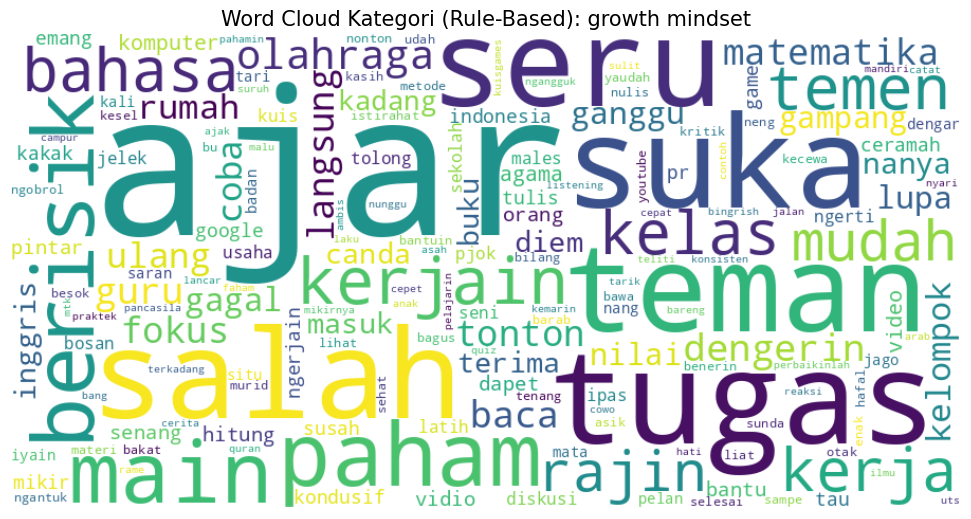

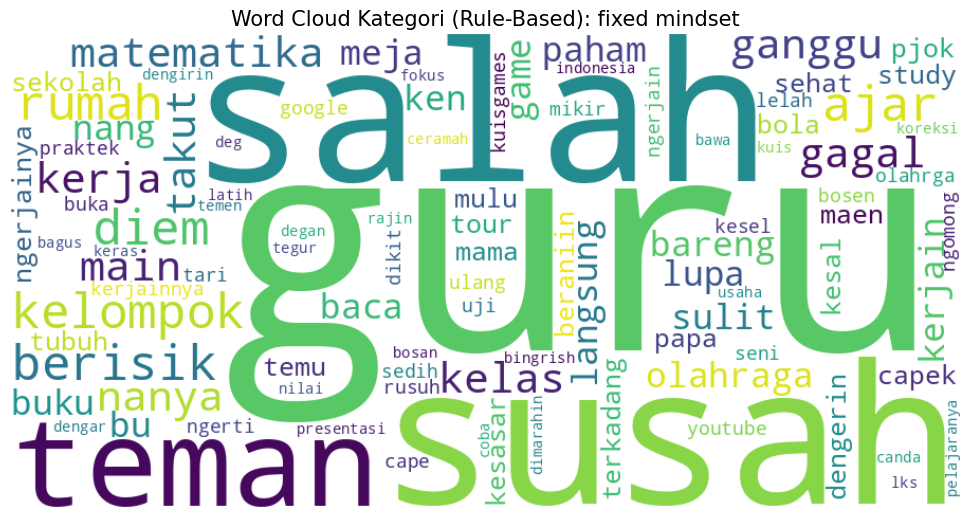

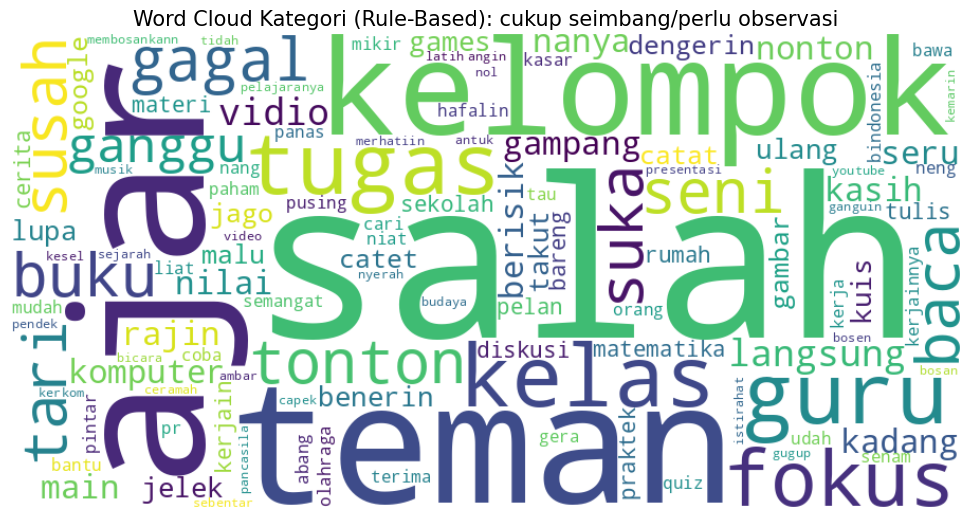

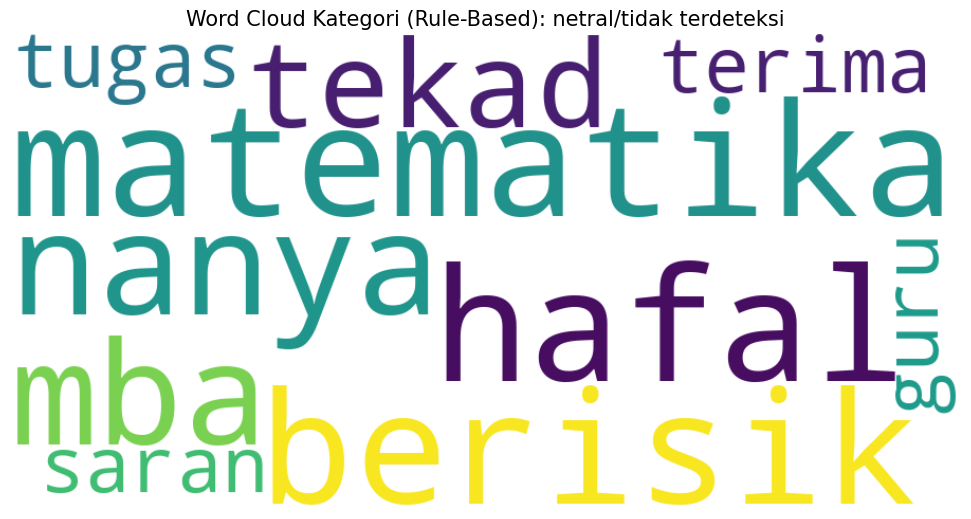

In [ ]:
if 'df_for_ml' in locals() and 'all_processed_text_ml' in df_for_ml.columns and 'Target_Kategori' in df_for_ml.columns:
    unique_categories_wc = df_for_ml['Target_Kategori'].unique()
    stopwords_wc = set(stop_words_indonesian)

    for category in unique_categories_wc:
        if pd.isna(category): continue
        text_cat = " ".join(txt for txt in df_for_ml[df_for_ml['Target_Kategori'] == category]['all_processed_text_ml'] if isinstance(txt, str) and txt.strip())
        if not text_cat.strip():
            print(f"Tidak ada teks untuk word cloud kategori: {category}")
            continue
        try:
            wordcloud = WordCloud(stopwords=stopwords_wc, background_color="white", width=900, height=450, colormap='viridis', min_font_size=10, collocations=False).generate(text_cat)
            plt.figure(figsize=(10, 5)); plt.imshow(wordcloud, interpolation='bilinear'); plt.axis("off")
            plt.title(f"Word Cloud Kategori (Rule-Based): {category}", fontsize=15); plt.tight_layout(pad=0); plt.show()
        except ValueError as e:
             print(f"Gagal membuat WC untuk '{category}': {e}")
else:
    print("Data untuk Word Cloud belum siap.")

ANALISIS POLA PIKIR SISWA SD

1. DISTRIBUSI POLA PIKIR (RULE-BASED)


,Jumlah Siswa,Persentase (%)
Rule_Kategori,,
growth mindset,71,77.2
cukup seimbang/perlu observasi,11,12.0
fixed mindset,9,9.8
netral/tidak terdeteksi,1,1.1



Ringkasan:
- Siswa dengan Growth Mindset: 71 (77.2%)
- Siswa dengan Non-Growth Mindset: 21 (22.8%)


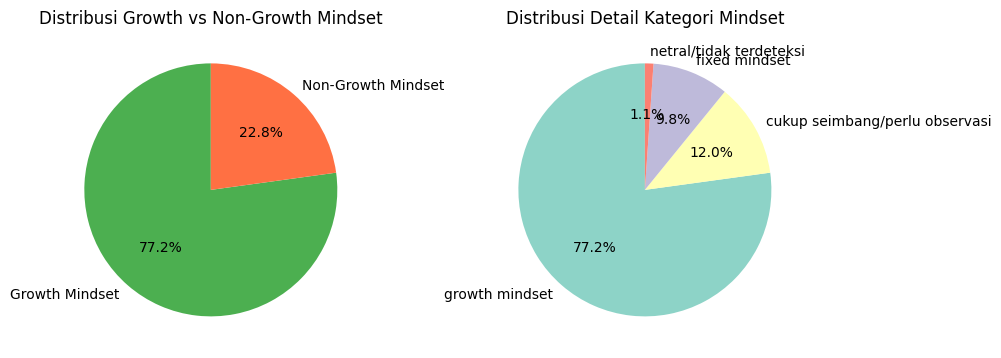


2. DISTRIBUSI POLA PIKIR (PREDIKSI MODEL ML)


,Jumlah Siswa,Persentase (%)
ML_Predicted_Kategori,,
growth mindset,78,84.8
cukup seimbang/perlu observasi,9,9.8
fixed mindset,4,4.3
netral/tidak terdeteksi,1,1.1



Ringkasan (Prediksi ML - SVM (class_weight='balanced')):
- Siswa dengan Growth Mindset: 78 (84.8%)
- Siswa dengan Non-Growth Mindset: 14 (15.2%)


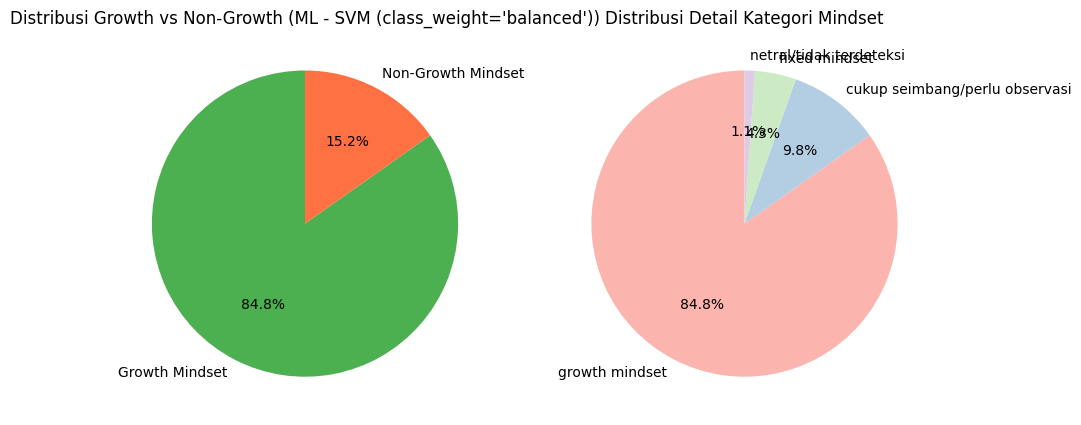

In [ ]:
print("=" * 50)
print("ANALISIS POLA PIKIR SISWA SD")
print("=" * 50)

if 'result_df_rules' in locals():
    print("\n1. DISTRIBUSI POLA PIKIR (RULE-BASED)")
    kategori_count = result_df_rules['Rule_Kategori'].value_counts()
    kategori_percent = result_df_rules['Rule_Kategori'].value_counts(normalize=True).round(3) * 100

    distribusi_df = pd.DataFrame({
        'Jumlah Siswa': kategori_count,
        'Persentase (%)': kategori_percent
    }).sort_values('Jumlah Siswa', ascending=False)

    display(distribusi_df)
    growth_count = kategori_count.get('growth mindset', 0)
    total_siswa = len(result_df_rules)
    non_growth_count = total_siswa - growth_count

    print(f"\nRingkasan:")
    print(f"- Siswa dengan Growth Mindset: {growth_count} ({growth_count/total_siswa*100:.1f}%)")
    print(f"- Siswa dengan Non-Growth Mindset: {non_growth_count} ({non_growth_count/total_siswa*100:.1f}%)")

    # Warna pie chart lembut
    soft_colors = ['#4CAF50', '#FF7043']

    plt.figure(figsize=(10, 6))

    plt.subplot(1, 2, 1)
    labels = ['Growth Mindset', 'Non-Growth Mindset']
    sizes = [growth_count, non_growth_count]
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=soft_colors)
    plt.title('Distribusi Growth vs Non-Growth Mindset')

    plt.subplot(1, 2, 2)
    kategori_count.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
    plt.title('Distribusi Detail Kategori Mindset')
    plt.ylabel('')

    plt.tight_layout()
    plt.show()

if 'chosen_model_final' in locals() and chosen_model_final is not None and 'df_for_ml' in locals():
    print("\n2. DISTRIBUSI POLA PIKIR (PREDIKSI MODEL ML)")
    if 'df_export_ml_final' in locals() and 'ML_Predicted_Kategori' in df_export_ml_final.columns:
        ml_kategori_count = df_export_ml_final['ML_Predicted_Kategori'].value_counts()
        ml_kategori_percent = df_export_ml_final['ML_Predicted_Kategori'].value_counts(normalize=True).round(3) * 100

        ml_distribusi_df = pd.DataFrame({
            'Jumlah Siswa': ml_kategori_count,
            'Persentase (%)': ml_kategori_percent
        }).sort_values('Jumlah Siswa', ascending=False)

        display(ml_distribusi_df)

        ml_growth_count = ml_kategori_count.get('growth mindset', 0)
        ml_total_siswa = len(df_export_ml_final)
        ml_non_growth_count = ml_total_siswa - ml_growth_count

        print(f"\nRingkasan (Prediksi ML - {model_name_final}):")
        print(f"- Siswa dengan Growth Mindset: {ml_growth_count} ({ml_growth_count/ml_total_siswa*100:.1f}%)")
        print(f"- Siswa dengan Non-Growth Mindset: {ml_non_growth_count} ({ml_non_growth_count/ml_total_siswa*100:.1f}%)")

        # Warna konsisten
        plt.figure(figsize=(10, 6))

        plt.subplot(1, 2, 1)
        labels = ['Growth Mindset', 'Non-Growth Mindset']
        sizes = [ml_growth_count, ml_non_growth_count]
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=soft_colors)
        plt.title(f'Distribusi Growth vs Non-Growth (ML - {model_name_final})')

        plt.subplot(1, 2, 2)
        ml_kategori_count.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.cm.Pastel1.colors)
        plt.title('Distribusi Detail Kategori Mindset')
        plt.ylabel('')

        plt.tight_layout()
        plt.show()


**13. Ekspor Hasil Akhir ke Google Spreadsheet**

In [ ]:
if 'client' in locals() and 'spreadsheet' in locals() and 'df' in locals() and 'result_df_rules' in locals():
    df_export_rules = result_df_rules.copy()

    sheet_title_rules_export = "Hasil Analisis Rule-Based V2"
    try:
        worksheet_rules_export = spreadsheet.worksheet(sheet_title_rules_export)
        worksheet_rules_export.clear()
    except gspread.exceptions.WorksheetNotFound:
        worksheet_rules_export = spreadsheet.add_worksheet(title=sheet_title_rules_export, rows=len(df_export_rules)+1, cols=len(df_export_rules.columns)+1)
    set_with_dataframe(worksheet_rules_export, df_export_rules, include_index=False, resize=True)
    print(f"✅ Hasil rule-based dikirim ke: {sheet_title_rules_export}")

    if chosen_model_final and 'df_for_ml' in locals():
        X_full_dataset_tfidf = vectorizer.transform(df_for_ml['all_processed_text_ml'])
        full_dataset_ml_predictions = chosen_model_final.predict(X_full_dataset_tfidf)

        df_export_ml_final = df_for_ml[['Nama', 'Kelas_Asal', 'all_processed_text_ml']].copy()
        df_export_ml_final['ML_Predicted_Kategori'] = full_dataset_ml_predictions
        df_export_ml_final['ML_Model_Used'] = model_name_final
        df_export_ml_final['Original_Rule_Based_Kategori'] = df_for_ml['Target_Kategori']

        if hasattr(chosen_model_final, 'predict_proba'):
            full_dataset_ml_probas = chosen_model_final.predict_proba(X_full_dataset_tfidf)
            pred_classes_indices = [list(chosen_model_final.classes_).index(cls) for cls in full_dataset_ml_predictions]
            df_export_ml_final['ML_Confidence'] = [full_dataset_ml_probas[i, idx] for i, idx in enumerate(pred_classes_indices)]

        sheet_title_ml_export = "Hasil Prediksi ML Final V2"
        try:
            worksheet_ml_export = spreadsheet.worksheet(sheet_title_ml_export)
            worksheet_ml_export.clear()
        except gspread.exceptions.WorksheetNotFound:
            worksheet_ml_export = spreadsheet.add_worksheet(title=sheet_title_ml_export, rows=len(df_export_ml_final)+1, cols=len(df_export_ml_final.columns)+1)
        set_with_dataframe(worksheet_ml_export, df_export_ml_final, include_index=False, resize=True)
        print(f"✅ Hasil prediksi ML terbaik dikirim ke: {sheet_title_ml_export}")
    else:
        print("Model ML terbaik belum dipilih atau data tidak siap untuk ekspor prediksi ML.")
else:
    print("Variabel (client, spreadsheet, df, hasil analisis) belum siap untuk ekspor.")

✅ Hasil rule-based dikirim ke: Hasil Analisis Rule-Based V2
✅ Hasil prediksi ML terbaik dikirim ke: Hasil Prediksi ML Final V2


**Analisis Selesai.**